In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

In [3]:
df_sample_submission = pd.read_csv('/content/drive/My Drive/ColabNotebooks/sample_submission.csv')
df_movies = pd.read_csv('/content/drive/My Drive/ColabNotebooks/movies.csv')
df_imdb = pd.read_csv('/content/drive/My Drive/ColabNotebooks/imdb_data.csv')
df_genome_scores = pd.read_csv('/content/drive/My Drive/ColabNotebooks/genome_scores.csv')
df_genome_tags = pd.read_csv('/content/drive/My Drive/ColabNotebooks/genome_tags.csv')
df_train = pd.read_csv('/content/drive/My Drive/ColabNotebooks/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/ColabNotebooks/test.csv')
df_tags = pd.read_csv('/content/drive/My Drive/ColabNotebooks/tags.csv')
df_links = pd.read_csv('/content/drive/My Drive/ColabNotebooks/links.csv')

In [ ]:
df_train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [4]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


I wish to split the title of the movies dataframe into a titel and year columns:

In [5]:
titles = []
years = []

for t in df_movies.title:
  split = t.split("(")
  titles.append(split[0])
  years.append(split[-1])

df_movies['title'] = titles
df_movies['year'] = years

df_movies.head()



,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995)
1,2,Jumanji,Adventure|Children|Fantasy,1995)
2,3,Grumpier Old Men,Comedy|Romance,1995)
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995)
4,5,Father of the Bride Part II,Comedy,1995)


In [6]:
df_movies['year'] = df_movies.year.str.extract("(\d+)")

In [7]:
df_movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [8]:
df_movies.year.isnull().sum()

388

In [9]:
df_movies.isnull().sum()

movieId      0
title        0
genres       0
year       388
dtype: int64

In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
 3   year     62035 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


In [10]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres',])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


In [11]:
movies_genres = pd.merge(movies_genres, df_movies[['movieId','title', 'year']], on='movieId', how='left')
movies_genres.head()

,movieId,genres,title,year
0,1,Adventure,Toy Story,1995
1,1,Animation,Toy Story,1995
2,1,Children,Toy Story,1995
3,1,Comedy,Toy Story,1995
4,1,Fantasy,Toy Story,1995


CREATE A COPY OF MOVIES_GENRES DATAFRAME:

In [12]:
movies1 = movies_genres.copy()

In [13]:
movies1.dropna(inplace=True)

In [14]:
movies1.isnull().sum()

movieId    0
genres     0
title      0
year       0
dtype: int64

In [ ]:
movies1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111842 entries, 0 to 112306
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   movieId  111842 non-null  int64 
 1   genres   111842 non-null  object
 2   title    111842 non-null  object
 3   year     111842 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.3+ MB


In [15]:
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [ ]:
np.array(df_imdb['budget'].unique())

array(['$30,000,000', '$65,000,000', '$25,000,000', ..., 'DKK35,000,000',
       'EUR90,000', 'DEM5,800,000'], dtype=object)

In [16]:
df_imdb['budget'] = df_imdb['budget'].str.replace(r'$', 'USD')

In [17]:
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"USD30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"USD65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"USD25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"USD16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"USD30,000,000",fatherhood|doberman|dog|mansion


In [18]:
df_imdb['currency'] = df_imdb['budget'].str.extract(r'([a-zA-Z]*)')

In [19]:
df_imdb['budget'] = df_imdb['budget'].str.replace(r'[a-zA-Z]', '')

In [20]:
list(df_imdb['budget'].unique())

['30,000,000',
 '65,000,000',
 '25,000,000',
 '16,000,000',
 '60,000,000',
 '58,000,000',
 nan,
 '35,000,000',
 '62,000,000',
 '44,000,000',
 '98,000,000',
 '52,000,000',
 '4,000,000',
 '68,000,000',
 '30,250,000',
 '20,000,000',
 '50,000,000',
 '9,500,000',
 '3,600,000',
 '11,000,000',
 '18,000,000',
 '23,000,000',
 '29,000,001',
 '12,000,000',
 '6,000,000',
 '10,000,000',
 '19,000,000',
 '33,000,000',
 '55,000,000',
 '15,000,000',
 '3,000,000',
 '45,000,000',
 '3,800,000',
 '3,500,000',
 '9,000,000',
 '150,000',
 '7,000,000',
 '1,500,000',
 '4,997,987',
 '38,000,000',
 '47,000,000',
 '2,590,000',
 '40,000,000',
 '24,000,000',
 '72,000,000',
 '7,500,000',
 '5,000,000',
 '42,000,000',
 '17,000,000',
 '31,000,000',
 '238,000',
 '2,000,000',
 '2,300,000',
 '28,000,000',
 '100,000,000',
 '53,000,000',
 '27,000,000',
 '90,000,000',
 '26,000,000',
 '500,000',
 '1,000,000',
 '22,000,000',
 '8,000,000',
 '46,000,000',
 '13,000,000',
 '175,000,000',
 '2,800,000',
 '1,900,000',
 '2,500,000',
 '

In [21]:
list(df_imdb.currency.unique())

['USD',
 nan,
 'GBP',
 'EUR',
 'CAD',
 'FRF',
 'DEM',
 'AUD',
 'ISK',
 'JPY',
 'HKD',
 'CHF',
 'ESP',
 'INR',
 'BEF',
 'SEK',
 'ATS',
 'NOK',
 'FIM',
 'SGD',
 'DKK',
 'THB',
 'BRL',
 'NLG',
 'BND',
 'CNY',
 'NZD',
 'HUF',
 'CZK',
 'PLN',
 'KRW',
 'TRL',
 'ZAR',
 'EGP',
 'BGL',
 'TWD',
 'IDR',
 'SIT',
 'MYR',
 'ILS',
 'CLP',
 'MXN',
 'COP',
 'LTL',
 'ARS',
 'IRR',
 'PTE',
 'VEB',
 'UAH',
 'NGN',
 'ITL',
 'LVL',
 'RUR',
 'PHP']

In [22]:
df_imdb.currency.fillna('USD')

0        USD
1        USD
2        USD
3        USD
4        USD
        ... 
27273    USD
27274    DEM
27275    USD
27276    USD
27277    USD
Name: currency, Length: 27278, dtype: object

In [23]:
len(df_imdb.currency.unique())

54

In [24]:
df_imdb['budget'] = df_imdb['budget'].str.replace(',', '')

In [25]:
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords,currency
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,30000000,toy|rivalry|cowboy|cgi animation,USD
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,65000000,board game|adventurer|fight|game,USD
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,25000000,boat|lake|neighbor|rivalry,USD
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,16000000,black american|husband wife relationship|betra...,USD
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,30000000,fatherhood|doberman|dog|mansion,USD


ATTEMPTING TO USE CURRENCY CONVERTER TO CONVERT ALL BUDGETS TO DOLLARS

### FOREX ROUTE

In [ ]:
pip install forex-python

     |████████████████████████████████| 133kB 5.9MB/s 


In [ ]:
from forex_python.converter import CurrencyRates

In [ ]:
c = CurrencyRates()

In [ ]:
c.get_rates('USD')

{'AUD': 1.3205778003041053,
 'BGN': 1.6521371853353608,
 'BRL': 5.093090048994763,
 'CAD': 1.2366953877344147,
 'CHF': 0.9232978543672917,
 'CNY': 6.466041561074506,
 'CZK': 21.633721912485218,
 'DKK': 6.2815509376583885,
 'EUR': 0.8447372867038352,
 'GBP': 0.7218280114884271,
 'HKD': 7.7666835614124015,
 'HRK': 6.323280959621558,
 'HUF': 298.5301571211353,
 'IDR': 14488.418651799291,
 'INR': 74.51647237709072,
 'ISK': 124.26085487413414,
 'JPY': 110.65213718533538,
 'KRW': 1133.3586754519345,
 'MXN': 19.816692008785267,
 'MYR': 4.155516134482176,
 'NOK': 8.628991383679676,
 'NZD': 1.4109646899814157,
 'PHP': 49.630849805710426,
 'PLN': 3.7963338401757056,
 'RON': 4.161513769217773,
 'RUB': 73.46899814157797,
 'SEK': 8.573238722757223,
 'SGD': 1.3448217604325057,
 'THB': 32.209832742017234,
 'TRY': 8.659739820915696,
 'ZAR': 14.215070113194797}

In [ ]:
c.convert('GBP', 'USD', 10)

13.853715623171446

### PYCURRENCY ROUTE

In [26]:
pip install CurrencyConverter

     |████████████████████████████████| 532kB 4.0MB/s 


In [27]:
from currency_converter import CurrencyConverter

In [28]:
c = CurrencyConverter()

In [29]:
c.convert(100, 'EUR', 'USD')

118.22999999999999

In [30]:
currencies = list(c.currencies)
currencies

['RUB',
 'RON',
 'JPY',
 'DKK',
 'HKD',
 'LTL',
 'SEK',
 'NOK',
 'TRY',
 'PLN',
 'BGN',
 'ILS',
 'CAD',
 'BRL',
 'PHP',
 'SGD',
 'LVL',
 'EUR',
 'USD',
 'KRW',
 'EEK',
 'IDR',
 'NZD',
 'MTL',
 'ISK',
 'THB',
 'CHF',
 'MXN',
 'GBP',
 'TRL',
 'ZAR',
 'CZK',
 'HUF',
 'SKK',
 'ROL',
 'AUD',
 'INR',
 'CNY',
 'CYP',
 'SIT',
 'HRK',
 'MYR']

In [ ]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
 6   currency       7906 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.5+ MB


In [ ]:
df_imdb['title_cast'] = df_imdb['title_cast'].str.replace("|", ",")
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords,currency
0,1,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,81.0,30000000,toy|rivalry|cowboy|cgi animation,USD
1,2,"Robin Williams,Jonathan Hyde,Kirsten Dunst,Bra...",Jonathan Hensleigh,104.0,65000000,board game|adventurer|fight|game,USD
2,3,"Walter Matthau,Jack Lemmon,Sophia Loren,Ann-Ma...",Mark Steven Johnson,101.0,25000000,boat|lake|neighbor|rivalry,USD
3,4,"Whitney Houston,Angela Bassett,Loretta Devine,...",Terry McMillan,124.0,16000000,black american|husband wife relationship|betra...,USD
4,5,"Steve Martin,Diane Keaton,Martin Short,Kimberl...",Albert Hackett,106.0,30000000,fatherhood|doberman|dog|mansion,USD


In [ ]:
cast = []

for size in df_imdb['title_cast'].str.split(","):
  cast.append(size)

cast

[['Tom Hanks',
  'Tim Allen',
  'Don Rickles',
  'Jim Varney',
  'Wallace Shawn',
  'John Ratzenberger',
  'Annie Potts',
  'John Morris',
  'Erik von Detten',
  'Laurie Metcalf',
  'R. Lee Ermey',
  'Sarah Freeman',
  'Penn Jillette',
  'Jack Angel',
  'Spencer Aste'],
 ['Robin Williams',
  'Jonathan Hyde',
  'Kirsten Dunst',
  'Bradley Pierce',
  'Bonnie Hunt',
  'Bebe Neuwirth',
  'David Alan Grier',
  'Patricia Clarkson',
  'Adam Hann-Byrd',
  'Laura Bell Bundy',
  'James Handy',
  'Gillian Barber',
  'Brandon Obray',
  'Cyrus Thiedeke',
  'Gary Joseph Thorup'],
 ['Walter Matthau',
  'Jack Lemmon',
  'Sophia Loren',
  'Ann-Margret',
  'Burgess Meredith',
  'Daryl Hannah',
  'Kevin Pollak',
  'Katie Sagona',
  'Ann Morgan Guilbert',
  'James Andelin',
  'Marcus Klemp',
  'Max Wright',
  'Cheryl Hawker',
  'Wayne A. Evenson',
  'Allison Levine'],
 ['Whitney Houston',
  'Angela Bassett',
  'Loretta Devine',
  'Lela Rochon',
  'Gregory Hines',
  'Dennis Haysbert',
  'Mykelti Williamson

In [ ]:
cast_size = []

for size in df_imdb['title_cast'].str.count(","):
  cast_size.append(size + 1)

df_imdb['cast_size'] = cast_size

In [ ]:
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords,currency,cast_size
0,1,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,81.0,30000000,toy|rivalry|cowboy|cgi animation,USD,15.0
1,2,"Robin Williams,Jonathan Hyde,Kirsten Dunst,Bra...",Jonathan Hensleigh,104.0,65000000,board game|adventurer|fight|game,USD,15.0
2,3,"Walter Matthau,Jack Lemmon,Sophia Loren,Ann-Ma...",Mark Steven Johnson,101.0,25000000,boat|lake|neighbor|rivalry,USD,15.0
3,4,"Whitney Houston,Angela Bassett,Loretta Devine,...",Terry McMillan,124.0,16000000,black american|husband wife relationship|betra...,USD,15.0
4,5,"Steve Martin,Diane Keaton,Martin Short,Kimberl...",Albert Hackett,106.0,30000000,fatherhood|doberman|dog|mansion,USD,15.0


In [ ]:
df_imdb.tail(15)

,movieId,title_cast,director,runtime,budget,plot_keywords,currency,cast_size
27263,131176,"Nikolaj Coster-Waldau,Ulrich Thomsen,Nikolaj L...",Susanne Bier,102.0,35000000,f rated,DKK,15.0
27264,131180,"Jesse Metcalfe,Meghan Ory,Virginia Madsen,Keeg...",Tim Carter,118.0,NaN,quarantine|zombie|shot dead|zombie infection,NaN,15.0
27265,131231,"Jessica Paré,Brian Gleeson,Stanley Townsend,Fr...",Rob Burke,90.0,NaN,NaN,NaN,15.0
27266,131237,"Leonid Barats,Aleksandr Demidov,Kamil Larin,Ro...",Leonid Barats,93.0,NaN,road trip|russia|eavesdropping|advertising,NaN,15.0
27267,131239,"Elmar Wepper,Mercan-Fatima Türköglu,Ivan Ander...",Christian Zübert,NaN,NaN,taxi|girl alone|taxi driver|mutual understanding,NaN,15.0
27268,131241,"Tobias Schenke,Axel Stein,Luise Helm,Mina Tand...",Granz Henman,95.0,NaN,male objectification|gay|modern day adaptation...,NaN,15.0
27269,131243,"Klaus Büchner,Andi Feldmann,Kulle Westphal,Ber...",Toby Genkel,76.0,NaN,vomiting|based on comic|drunk driver|beer drin...,NaN,13.0
27270,131248,"Patrick Dempsey,Mandy Moore,Jeremy Suarez,Rick...",Rich Burns,NaN,NaN,bear|finale|series finale|hate,NaN,15.0
27271,131250,"Daniel Brühl,Jasmin Schwiers,Niels-Bruno Schmi...",Marco Petry,NaN,NaN,hot|sex scene,NaN,15.0
27272,131252,"Konstantin Graudus,Gustav Adolph Artz,Jürgen K...",Jörg Wagner,10.0,90000,safety|forklift|spoof|blood,EUR,15.0


In [ ]:
df_imdb.isnull().sum()

movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
currency         19372
cast_size        10068
dtype: int64

FOR THE SAKE OF EDA, LET'S DROP THE PLOT_KEYWORDS COLUMN:

In [ ]:
df_imdb.drop('plot_keywords', axis=1, inplace=True)

In [ ]:
df_imdb.head()

,movieId,title_cast,director,runtime,budget,currency,cast_size
0,1,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,81.0,30000000,USD,15.0
1,2,"Robin Williams,Jonathan Hyde,Kirsten Dunst,Bra...",Jonathan Hensleigh,104.0,65000000,USD,15.0
2,3,"Walter Matthau,Jack Lemmon,Sophia Loren,Ann-Ma...",Mark Steven Johnson,101.0,25000000,USD,15.0
3,4,"Whitney Houston,Angela Bassett,Loretta Devine,...",Terry McMillan,124.0,16000000,USD,15.0
4,5,"Steve Martin,Diane Keaton,Martin Short,Kimberl...",Albert Hackett,106.0,30000000,USD,15.0


CREATE A COPY OF DATAFRAME HERE: GOING TO DROP ALL OBSERVATIONS CONTAINING NAN VALUES:

In [31]:
imdb1 = df_imdb.copy()

In [33]:
imdb1.dropna(inplace=True)

In [34]:
imdb1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6963 entries, 0 to 27274
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        6963 non-null   int64  
 1   title_cast     6963 non-null   object 
 2   director       6963 non-null   object 
 3   runtime        6963 non-null   float64
 4   budget         6963 non-null   object 
 5   plot_keywords  6963 non-null   object 
 6   currency       6963 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 435.2+ KB


In [35]:
imdb1['budget'] = imdb1.budget.astype(float)

In [36]:
imdb1.isnull().sum()

movieId          0
title_cast       0
director         0
runtime          0
budget           0
plot_keywords    0
currency         0
dtype: int64

In [37]:
currency_match = []

for curr in imdb1.currency:
  if curr in currencies:
    currency_match.append(curr)

  else:
    curr = np.nan
    currency_match.append(curr)

imdb1['currency'] = currency_match

In [38]:
imdb1['currency'].unique()

array(['USD', 'GBP', 'EUR', 'CAD', nan, 'AUD', 'JPY', 'HKD', 'CHF', 'INR',
       'SEK', 'NOK', 'SGD', 'DKK', 'THB', 'BRL', 'CNY', 'NZD', 'HUF',
       'KRW', 'CZK', 'PLN', 'ISK', 'TRL', 'IDR', 'ILS', 'MYR', 'MXN',
       'LVL', 'PHP'], dtype=object)

In [39]:
imdb1.dropna(inplace=True)

In [40]:
imdb1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6843 entries, 0 to 27272
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        6843 non-null   int64  
 1   title_cast     6843 non-null   object 
 2   director       6843 non-null   object 
 3   runtime        6843 non-null   float64
 4   budget         6843 non-null   float64
 5   plot_keywords  6843 non-null   object 
 6   currency       6843 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 427.7+ KB


In [41]:
len(imdb1.currency.unique())

29

NOW THE TRICK IS TO CREATE A NEW COLUMN, WITH THE ADJUSTED BUDGET, BASED ON THE EXCHANGE RATE:

In [42]:
exchange_rate = []
adjusted_budget = []

for curr in imdb1.currency:
  e_rate = c.convert(1, curr, 'USD')
  exchange_rate.append(e_rate)
  

imdb1['exchange_rate'] = exchange_rate
imdb1.tail(20)

,movieId,title_cast,director,runtime,budget,plot_keywords,currency,exchange_rate
27105,130398,Matthew Wolf|Amy Weber|Shaley Scott|Eliza Swen...,Leigh Scott,86.0,250000.0,machine|robot|mockbuster|violence,USD,1.000000
27111,130424,Alicia Vikander|Bill Skarsgård|Loa Falkman|Noa...,Carina Dahl,120.0,48000000.0,seal the animal|watching television|letter wri...,SEK,0.116388
27118,130474,Michelle Williams|Kristin Scott Thomas|Margot ...,Matthias Schoenaerts,107.0,15000000.0,france|german occupation of france|world war t...,EUR,1.182300
27122,130490,Kate Winslet|Jai Courtney|Mekhi Phifer|Shailen...,Brian Duffield,119.0,110000000.0,truth serum|on the run|trainhopping|falling fr...,USD,1.000000
27124,130496,Samuel L. Jackson|Onni Tommila|Ray Stevenson|V...,Jalmari Helander,90.0,8500000.0,president|air force one|escape pod|wilderness,EUR,1.182300
27136,130520,Jim Parsons|Rihanna|Steve Martin|Jennifer Lope...,Tom J. Astle,94.0,135000000.0,mother daughter relationship|alien|human|frien...,USD,1.000000
27139,130526,Aaron Kwok|Patrick Tam|Beibi Gong|Hin-Wai Au|E...,Oxide Chun Pang,104.0,9000000.0,Crime,USD,1.000000
27143,130578,Sean Penn|Jasmine Trinca|Javier Bardem|Ray Win...,Jean-Patrick Manchette,115.0,40000000.0,blood vomiting|interpol|kicked in the face|eye...,USD,1.000000
27146,130588,Josh Hutcherson|Benicio Del Toro|Brady Corbet|...,Andrea Di Stefano,120.0,17000000.0,pablo escobar|tragic ending|drug lord|colombia,USD,1.000000
27183,130976,Danila Kozlovsky|Oleg Menshikov|Svetlana Ivano...,Nikolay Kulikov,134.0,10000000.0,ice hockey|russia|number 7 in title|canada,EUR,1.182300


In [43]:
imdb1['budget'] = pd.to_numeric(imdb1['budget'], errors='coerce')

In [44]:
imdb1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6843 entries, 0 to 27272
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        6843 non-null   int64  
 1   title_cast     6843 non-null   object 
 2   director       6843 non-null   object 
 3   runtime        6843 non-null   float64
 4   budget         6843 non-null   float64
 5   plot_keywords  6843 non-null   object 
 6   currency       6843 non-null   object 
 7   exchange_rate  6843 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 481.1+ KB


In [45]:
arr1 = np.array(imdb1.budget)
arr2 = np.array(imdb1.exchange_rate)

adjusted_budget = np.multiply(arr1, arr2)

In [46]:
len(adjusted_budget)

6843

In [47]:
imdb1['adjusted_budget'] = adjusted_budget

In [48]:
imdb1.tail(15)

,movieId,title_cast,director,runtime,budget,plot_keywords,currency,exchange_rate,adjusted_budget
27136,130520,Jim Parsons|Rihanna|Steve Martin|Jennifer Lope...,Tom J. Astle,94.0,135000000.0,mother daughter relationship|alien|human|frien...,USD,1.000000,1.350000e+08
27139,130526,Aaron Kwok|Patrick Tam|Beibi Gong|Hin-Wai Au|E...,Oxide Chun Pang,104.0,9000000.0,Crime,USD,1.000000,9.000000e+06
27143,130578,Sean Penn|Jasmine Trinca|Javier Bardem|Ray Win...,Jean-Patrick Manchette,115.0,40000000.0,blood vomiting|interpol|kicked in the face|eye...,USD,1.000000,4.000000e+07
27146,130588,Josh Hutcherson|Benicio Del Toro|Brady Corbet|...,Andrea Di Stefano,120.0,17000000.0,pablo escobar|tragic ending|drug lord|colombia,USD,1.000000,1.700000e+07
27183,130976,Danila Kozlovsky|Oleg Menshikov|Svetlana Ivano...,Nikolay Kulikov,134.0,10000000.0,ice hockey|russia|number 7 in title|canada,EUR,1.182300,1.182300e+07
27192,131013,Will Ferrell|Kevin Hart|Craig T. Nelson|Alison...,Jay Martel,100.0,40000000.0,millionaire|singing in a car|wealth|mansion,USD,1.000000,4.000000e+07
27193,131015,William Hurt|Cary Elwes|Ploy Jindachote|Paula ...,John Penney,93.0,5000000.0,seeing dead people|luggage|car accident|learni...,USD,1.000000,5.000000e+06
27207,131062,Joshua Leonard|Azura Skye|Diane Salinger|Aaron...,Jim Torres,95.0,1000000.0,time in title|ventriloquist's dummy|post apoca...,USD,1.000000,1.000000e+06
27208,131066,Anders Juul|Hadi Ka-Koush|Lærke Winther|Brian ...,Thorbjørn Christoffersen,89.0,18000000.0,bloody violence|nudity|profanity|cgi animation,DKK,0.158997,2.861942e+06
27215,131080,Jennifer Hale|Christopher Daniel Barnes|Susann...,Dan Berendsen,74.0,8000000.0,heroine|father son relationship|little boy|party,USD,1.000000,8.000000e+06


In [49]:
imdb1[imdb1['movieId'] == 1721]

,movieId,title_cast,director,runtime,budget,plot_keywords,currency,exchange_rate,adjusted_budget
1661,1721,Leonardo DiCaprio|Kate Winslet|Billy Zane|Kath...,James Cameron,194.0,200000000.0,iceberg|sailor's death|wet|wetness,USD,1.0,200000000.0


In [ ]:
df_genome_scores.isnull().sum()

movieId      0
tagId        0
relevance    0
dtype: int64

GOING TO TRY USE RELEVANCE IN THE EDA BELOW

In [ ]:
len(df_genome_scores.movieId)

15584448

In [ ]:
df_genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [ ]:
df_tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [ ]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
df_train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [ ]:
df_train.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [ ]:
len(df_train.userId.unique())

162541

In [ ]:
len(df_train.movieId.unique())

48213

In [ ]:
len(df_movies.movieId.unique())

62423

Let's check the distribution of the ratings column:

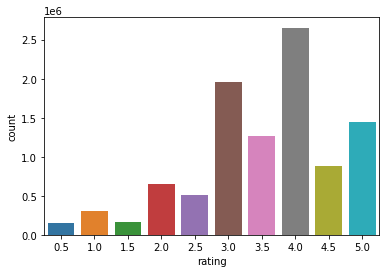

In [ ]:
sns.countplot(x='rating', data=df_train)
plt.show()

 **Merging df_train, df_imdb and df_movies **

In [ ]:
train_imdb_movies = pd.merge(pd.merge(df_train, df_imdb, on='movieId', how='left'), df_movies, on='movieId', how='left')
train_imdb_movies.head()

,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords,title,genres
0,5163,57669,4.0,1518349992,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"15,000,000",dwarf|bruges|irish|hitman,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,106343,5,4.5,1206238739,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"30,000,000",fatherhood|doberman|dog|mansion,Father of the Bride Part II (1995),Comedy
2,146790,5459,5.0,1076215539,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"140,000,000",lingerie|michael jackson character|shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi
3,106362,32296,2.0,1423042565,Sandra Bullock|Regina King|Enrique Murciano|Wi...,Marc Lawrence,115.0,"45,000,000",female protagonist|cleave gag|good woman|fbi,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime
4,9041,366,3.0,833375837,Jeff Davis|Heather Langenkamp|Miko Hughes|Matt...,Wes Craven,112.0,"8,000,000",freddy krueger|elm street|famous director as h...,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller


In [ ]:
subset = train_imdb_movies[:10000][train_imdb_movies['runtime'] < 240.0]

subset.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords,title,genres
0,5163,57669,4.0,1518349992,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"15,000,000",dwarf|bruges|irish|hitman,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,106343,5,4.5,1206238739,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"30,000,000",fatherhood|doberman|dog|mansion,Father of the Bride Part II (1995),Comedy
2,146790,5459,5.0,1076215539,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"140,000,000",lingerie|michael jackson character|shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi
3,106362,32296,2.0,1423042565,Sandra Bullock|Regina King|Enrique Murciano|Wi...,Marc Lawrence,115.0,"45,000,000",female protagonist|cleave gag|good woman|fbi,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime
4,9041,366,3.0,833375837,Jeff Davis|Heather Langenkamp|Miko Hughes|Matt...,Wes Craven,112.0,"8,000,000",freddy krueger|elm street|famous director as h...,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller


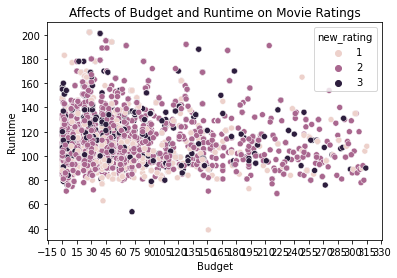

In [ ]:
import matplotlib.ticker as ticker

ax = sns.scatterplot(x='budget', y='runtime', hue='new_rating', data=subset)
plt.title('Affects of Budget and Runtime on Movie Ratings')
plt.xlabel('Budget')
plt.ylabel('Runtime')
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

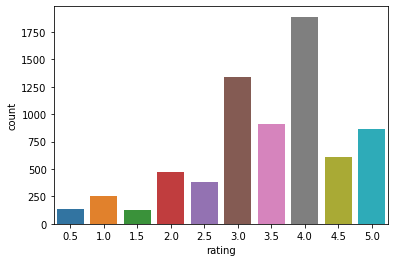

In [ ]:
sns.countplot(x='rating', data=subset)
plt.show()

In [ ]:
def reassign_rating(df):

  adjusted_rating = []

  for score in df['rating']:
    if score <= 2.5:
      score = 1
      adjusted_rating.append(score)
    
    elif score > 2.5 and score <=4:
      score = 2
      adjusted_rating.append(score)

    elif score > 4:
      score = 3
      adjusted_rating.append(score)

    df['new_rating'] = adjusted_rating

    return adjusted_rating

In [ ]:
adjusted_rating = []

for score in subset['rating']:

  if score <= 2.5:
    score = 1
    adjusted_rating.append(score)

  elif score > 2.5 and score <= 4:
    score = 2
    adjusted_rating.append(score)

  elif score > 4:
    score = 3
    adjusted_rating.append(score)

len(adjusted_rating)

subset['new_rating'] = adjusted_rating

In [ ]:
subset.head()

,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords,title,genres,new_rating
0,5163,57669,4.0,1518349992,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"15,000,000",dwarf|bruges|irish|hitman,In Bruges (2008),Comedy|Crime|Drama|Thriller,2
1,106343,5,4.5,1206238739,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"30,000,000",fatherhood|doberman|dog|mansion,Father of the Bride Part II (1995),Comedy,3
2,146790,5459,5.0,1076215539,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"140,000,000",lingerie|michael jackson character|shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi,3
3,106362,32296,2.0,1423042565,Sandra Bullock|Regina King|Enrique Murciano|Wi...,Marc Lawrence,115.0,"45,000,000",female protagonist|cleave gag|good woman|fbi,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime,1
4,9041,366,3.0,833375837,Jeff Davis|Heather Langenkamp|Miko Hughes|Matt...,Wes Craven,112.0,"8,000,000",freddy krueger|elm street|famous director as h...,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller,2


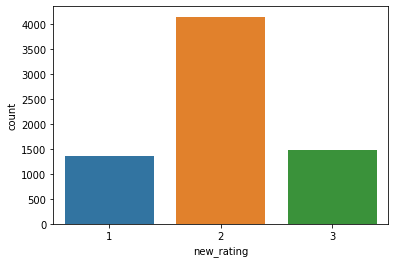

In [ ]:
sns.countplot(x='new_rating', data=subset)

In [ ]:
director = subset.groupby('director')[['Movie']]
director.head()

,userId,movieId,rating,timestamp,title_cast,director,runtime,budget,plot_keywords,title,genres,new_rating
1,106343,5,4.5,1206238739,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"30,000,000",fatherhood|doberman|dog|mansion,Father of the Bride Part II (1995),Comedy,3
2,146790,5459,5.0,1076215539,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"140,000,000",lingerie|michael jackson character|shorthaired...,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi,3
28,30258,4993,4.5,1114161086,Alan Howard|Noel Appleby|Sean Astin|Sala Baker...,J.R.R. Tolkien,178.0,"93,000,000",ring|quest|hobbit|elf,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,3
30,50882,89745,5.0,1549949960,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,Joss Whedon,143.0,"220,000,000",superhero|marvel cinematic universe|alien inva...,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX,3
36,104941,1909,5.0,975054915,David Duchovny|Gillian Anderson|John Neville|W...,Chris Carter,121.0,"66,000,000",agent|bomb|government|alien,"X-Files: Fight the Future, The (1998)",Action|Crime|Mystery|Sci-Fi|Thriller,3


### MERGING MOVIES1 AND IMDB1 DATAFRAME:

In [ ]:
len(movies1['movieId'])

111842

In [ ]:
len(imdb1['movieId'].unique())

7160

In [ ]:
merged1 = pd.merge(movies1, imdb1, on='movieId', how='inner')

In [ ]:
merged1

,movieId,genres,title,year,title_cast,director,runtime,budget,currency,cast_size
0,1,Adventure,Toy Story,1995,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,81.0,"30,000,000",,15.0
1,1,Animation,Toy Story,1995,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,81.0,"30,000,000",,15.0
2,1,Children,Toy Story,1995,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,81.0,"30,000,000",,15.0
3,1,Comedy,Toy Story,1995,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,81.0,"30,000,000",,15.0
4,1,Fantasy,Toy Story,1995,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,81.0,"30,000,000",,15.0
...,...,...,...,...,...,...,...,...,...,...
15217,131138,War,My Führer,2007,"Helge Schneider,Ulrich Mühe,Sylvester Groth,Ad...",Dani Levy,89.0,"1,000,000",EUR,15.0
15218,131176,Drama,A Second Chance,2014,"Nikolaj Coster-Waldau,Ulrich Thomsen,Nikolaj L...",Susanne Bier,102.0,"35,000,000",DKK,15.0
15219,131252,Comedy,Forklift Driver Klaus: The First Day on the Job,2001,"Konstantin Graudus,Gustav Adolph Artz,Jürgen K...",Jörg Wagner,10.0,"90,000",EUR,15.0
15220,131252,Horror,Forklift Driver Klaus: The First Day on the Job,2001,"Konstantin Graudus,Gustav Adolph Artz,Jürgen K...",Jörg Wagner,10.0,"90,000",EUR,15.0


In [ ]:
merged1.isnull().sum()

movieId       0
genres        0
title         0
year          0
title_cast    0
director      0
runtime       0
budget        0
currency      0
cast_size     0
dtype: int64

In [ ]:
merged2 = pd.merge(merged1, df_train, on='movieId', how='inner')

In [ ]:
merged2.head()

,movieId,genres,title,year,title_cast,director,runtime,budget,currency,cast_size,userId,rating,timestamp
0,1,Adventure,Toy Story,1995,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,81.0,"30,000,000",,15.0,158849,5.0,994716786
1,1,Adventure,Toy Story,1995,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,81.0,"30,000,000",,15.0,97203,5.0,942683155
2,1,Adventure,Toy Story,1995,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,81.0,"30,000,000",,15.0,161871,3.0,833104576
3,1,Adventure,Toy Story,1995,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,81.0,"30,000,000",,15.0,45117,4.0,1442256969
4,1,Adventure,Toy Story,1995,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,81.0,"30,000,000",,15.0,27431,5.0,849667827


In [ ]:
merged2.isnull().sum()

movieId       0
genres        0
title         0
year          0
title_cast    0
director      0
runtime       0
budget        0
currency      0
cast_size     0
userId        0
rating        0
timestamp     0
dtype: int64

In [ ]:
len(merged2.movieId)

18426562

18 million rows is way too mauch to run through each time when plotting a figure.

In [ ]:
eda = merged2.sample(n=1000, random_state=42)

In [ ]:
eda.head()

,movieId,genres,title,year,title_cast,director,runtime,budget,currency,cast_size,userId,rating,timestamp
18217446,112556,Drama,Gone Girl,2014,"Ben Affleck,Rosamund Pike,Neil Patrick Harris,...",Gillian Flynn,149.0,"61,000,000",,15.0,44557,5.0,1476140667
992565,150,Adventure,Apollo 13,1995,"Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,...",Jim Lovell,140.0,"52,000,000",,15.0,48206,4.0,1131223548
15685242,64957,Fantasy,"Curious Case of Benjamin Button, The",2008,"Cate Blanchett,Brad Pitt,Julia Ormond,Faune Ch...",Eric Roth,166.0,"150,000,000",,15.0,41013,4.0,1520816268
3938853,608,Crime,Fargo,1996,"William H. Macy,Steve Buscemi,Peter Stormare,K...",Ethan Coen,98.0,"7,000,000",,15.0,1807,4.0,971273222
9970430,4744,Horror,Jeepers Creepers,2001,"Gina Philips,Justin Long,Jonathan Breck,Patric...",Victor Salva,90.0,"10,000,000",,15.0,86339,0.5,1558563804


In [ ]:
eda.budget.unique()

array(['61,000,000', '52,000,000', '150,000,000', '7,000,000',
       '10,000,000', '47,000,000', '85,000,000', '50,000,000',
       '200,000,000', '6,000,000', '170,000,000', '31,000,000',
       '160,000,000', '48,000,000', '75,000,000', '5,000,000',
       '69,000,000', '92,000,000', '80,000,000', '60,000,000',
       '23,000,000', '93,000,000', '1,800,000', '20,000,000',
       '15,000,000', '140,000,000', '45,000,000', '250,000,000',
       '30,000,000', '90,000,000', '175,000,000', '35,000,000',
       '19,000,000', '57,000,000', '130,000,000', '94,000,000',
       '12,000,000', '225,000,000', '300,000,000', '36,000,000',
       '25,000,000', '165,000,000', '8,000,000', '102,000,000',
       '13,000,000', '55,000,000', '28,000,000', '11,000,000',
       '185,000,000', '58,000,000', '17,000,000', '72,000,000',
       '180,000,000', '115,000,000', '113,000,000', '1,000,000',
       '54,000,000', '70,000,000', '78,000,000', '27,000,000',
       '88,000,000', '59,000,000', '120,000,0

### UNIVARIATE ANALYSIS

WILL PERFORM UNIVARIATE ANALYSIS ON THE eda DATAFRAME:
THIS WAY, HOPEFULLY THE RAM WILL NOT BE UNDER TOO MUCH STRAIN...

In [ ]:
eda.describe()

,movieId,runtime,cast_size,userId,rating,timestamp
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,23877.206000,116.877000,14.929000,82171.594000,3.553500,1.244725e+09
std,34272.896945,22.987481,0.581633,46312.151332,1.048087,2.269031e+08
min,1.000000,76.000000,6.000000,19.000000,0.500000,8.280481e+08
25%,1048.500000,101.000000,15.000000,43822.250000,3.000000,1.066361e+09
50%,4306.000000,113.000000,15.000000,80962.000000,4.000000,1.261545e+09
75%,46542.000000,129.000000,15.000000,122609.000000,4.000000,1.454798e+09
max,119145.000000,242.000000,15.000000,162508.000000,5.000000,1.573907e+09


YEAR VARIABLE

In [ ]:
eda_year = eda.sort_values('year')
eda_year

,movieId,genres,title,year,title_cast,director,runtime,budget,currency,cast_size,userId,rating,timestamp
4895901,1249,Action,"Femme Nikita, La",1990,"Anne Parillaud,Marc Duret,Patrick Fontana,Alai...",Luc Besson,117.0,"50,000,000",FRF,15.0,112252,3.5,1169826757
6711953,2162,Adventure,"NeverEnding Story II: The Next Chapter, The",1990,"Jonathan Brandis,Kenny Morrison,Clarissa Burt,...",Karin Howard,90.0,"36,000,000",,15.0,51553,1.0,945070105
4887581,1245,Drama,Miller's Crossing,1990,"Gabriel Byrne,Marcia Gay Harden,John Turturro,...",Ethan Coen,115.0,"14,000,000",,15.0,38794,5.0,1508002767
4894545,1245,Thriller,Miller's Crossing,1990,"Gabriel Byrne,Marcia Gay Harden,John Turturro,...",Ethan Coen,115.0,"14,000,000",,15.0,136463,4.5,1200536367
11848054,6812,Thriller,"Rookie, The",1990,"Clint Eastwood,Charlie Sheen,Raul Julia,Sônia ...",Boaz Yakin,120.0,"10,000,000",,15.0,2685,2.0,1119615511
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18165837,111659,Adventure,Maleficent,2014,"Angelina Jolie,Elle Fanning,Sharlto Copley,Les...",Linda Woolverton,97.0,"180,000,000",,15.0,16322,3.0,1506160091
18064727,108932,Children,The Lego Movie,2014,"Will Arnett,Elizabeth Banks,Craig Berry,Alison...",Phil Lord,100.0,"60,000,000",,15.0,109934,5.0,1465529202
18199719,112175,Adventure,How to Train Your Dragon 2,2014,"Jay Baruchel,Cate Blanchett,Gerard Butler,Crai...",Dean DeBlois,102.0,"145,000,000",,15.0,39602,3.0,1541511851
18217446,112556,Drama,Gone Girl,2014,"Ben Affleck,Rosamund Pike,Neil Patrick Harris,...",Gillian Flynn,149.0,"61,000,000",,15.0,44557,5.0,1476140667


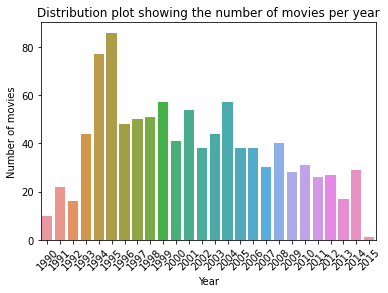

In [ ]:
ax = sns.countplot(x='year', data=eda_year)
plt.title('Distribution plot showing the number of movies per year')
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


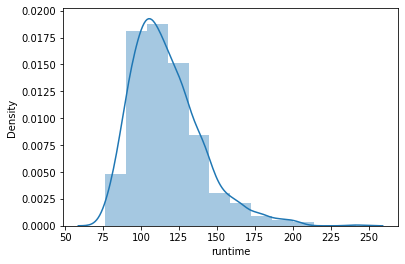

In [ ]:
sns.distplot(eda['runtime'], bins=12)
plt.show()

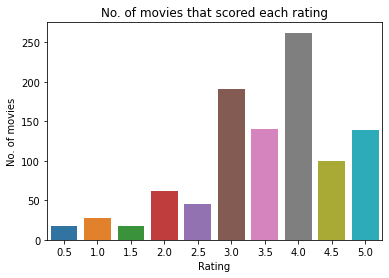

In [ ]:
sns.countplot(x='rating', data=eda)
plt.title('No. of movies that scored each rating')
plt.xlabel('Rating')
plt.ylabel('No. of movies')
plt.show()

Definite trend of users to score movies slightly above average.

GENRES

In [ ]:
movies_per_genre = eda.genres.value_counts()
movies_per_genre

Drama          171
Comedy         131
Action         121
Thriller        99
Adventure       92
Romance         77
Crime           55
Sci-Fi          54
Fantasy         37
Mystery         28
Horror          27
Children        24
IMAX            24
Animation       23
War             22
Musical          9
Western          4
Documentary      2
Name: genres, dtype: int64

In [ ]:
genres = eda.genres.unique()
genres

array(['Drama', 'Adventure', 'Fantasy', 'Crime', 'Horror', 'Comedy',
       'Thriller', 'Sci-Fi', 'Children', 'War', 'Action', 'Romance',
       'Animation', 'Musical', 'IMAX', 'Mystery', 'Western',
       'Documentary'], dtype=object)

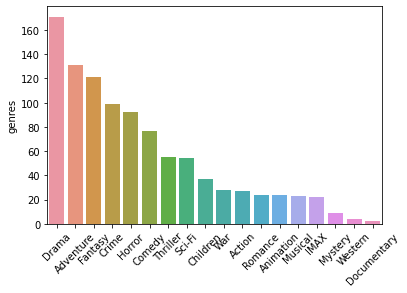

In [ ]:
sns.barplot(x=genres, y=movies_per_genre)
plt.xticks(rotation=45)
plt.show()

In [ ]:
eda_genres = eda.groupby('genres')['rating'].mean()
eda_genres

genres
Action         3.483471
Adventure      3.554348
Animation      3.760870
Children       3.729167
Comedy         3.408397
Crime          3.627273
Documentary    4.000000
Drama          3.646199
Fantasy        3.500000
Horror         3.333333
IMAX           3.354167
Musical        2.888889
Mystery        3.625000
Romance        3.688312
Sci-Fi         3.509259
Thriller       3.535354
War            3.909091
Western        3.625000
Name: rating, dtype: float64